In [1]:
import torch
import pandas as pd
import ltn
import numpy as np

from sklearn.model_selection import train_test_split

## Data Preparation

In [23]:
s_data = pd.read_csv('src\data\Stud_E-mobility_data_staticLimit.csv')

In [24]:
s_data = s_data[['_time','GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
      #  'DEMAND_LIMIT_INDICATOR', 
       'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY'
    ]]

In [25]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
s_data["DRAWN_FROM"] = s_data.apply(label_charging, axis=1)

In [26]:
s_data_small = s_data.sample(frac=0.4, random_state=42)

In [27]:
features = s_data.drop(['_time','DRAWN_FROM', 'BATTERY_DISCHARGE_POWER', 'BATTERY_CHARGED_ENERGY',  'BATTERY_DISCHARGED_ENERGY', 'GARAGE_EXTERNAL_POWER'], axis=1)
target = s_data['DRAWN_FROM']

In [28]:
# calculate number of points in each class
print(target.value_counts())

DRAWN_FROM
Battery Charged from Grid                          54783
Partially Covered by Local Battery                  4457
Battery Discharge Stopped due to Battery Health      202
Name: count, dtype: int64


## Tensor implementation tries

In [ ]:

# class Dataset:

#   def __init__(self, samples, labels, batch_size = 32):

#     self.samples = samples
#     self.labels = labels

#     self.batch_size = batch_size

#     self.length = int(np.ceil(samples.shape[0]/batch_size))

#     self.indices = np.arange(samples.shape[0]) 

#   def __getitem__(self, i):

#     i0 = i*self.batch_size
#     i1 = min((i + 1)*self.batch_size, self.samples.shape[0])

#     index = self.indices[i0:i1]

#     return self.samples[index], self.labels[index]

#   def __len__(self):
#     return self.length

#   def shuffle(self):
#     self.indices = np.random.permutation(self.indices)

In [ ]:

# class SubNetworkTF(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3):
#         super().__init__()
#         ks = (kernel_size, kernel_size)
#         self.f = nn.Sequential(
#             # Adjust the number of input and output channels
#             nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=ks, stride=1, padding=0),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.ReLU(),
#         )

#     def forward(self, x):
#         return self.f(x)

# class NetworkTF(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.f = nn.Sequential(
#             # The first block takes 1 input channel and produces 16 output channels
#             SubNetworkTF(in_channels=1, out_channels=16),
#             # The second block takes 16 input channels and produces 64 output channels
#             SubNetworkTF(in_channels=16, out_channels=64),

#             # Add a convolution layer with kernel size of 4 and 10 output channels
#             nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(4, 4), stride=1, padding=0),
            
#             # Flatten the output of the last convolution layer
#             nn.Flatten(),
#         )

#     def forward(self, x):
#         return self.f(x)



In [ ]:

# def fit(model, number_of_epochs, train_data, train_labels, val_data, val_labels):
#     # Define the CrossEntropyLoss and SGD optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.1)  

#     # Lists to store training and validation losses
#     training_losses = []
#     validation_losses = []

#     best_model = None
#     best_val_loss = float('inf')  # Initialize with a large value

#     for epoch in range(number_of_epochs):
#         # Set the model to training mode
#         model.train()

#         # Forward pass
#         train_outputs = model(train_data)
#         train_loss = criterion(train_outputs, train_labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         train_loss.backward()
#         optimizer.step()

#         # Set the model to evaluation mode
#         model.eval()

#         # Forward pass for validation
#         with torch.no_grad():
#             val_outputs = model(val_data)
#             val_loss = criterion(val_outputs, val_labels)

#         # Save training and validation losses
#         training_losses.append(train_loss.item())
#         validation_losses.append(val_loss.item())

#         # Update best model if current validation loss is lower
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model = model

#         print(f'Epoch [{epoch + 1}/{number_of_epochs}], '
#               f'Training Loss: {train_loss.item():.4f}, '
#               f'Validation Loss: {val_loss.item():.4f}')

#     return best_model, training_losses, validation_losses

In [ ]:
# # Define a function to convert labels to one-hot encoding
# def one_hot_encode(labels, num_classes):
#     return F.one_hot(labels, num_classes=num_classes)

# def preprocess_data(samples, labels):
#     print(labels)
#     labels = torch.Tensor(labels)  # Convert labels to PyTorch Tensor
#     labels_one_hot = one_hot_encode(labels.long(), num_classes=3)  # Assuming 3 classes
#     return torch.Tensor(samples.values), labels_one_hot  # Convert DataFrame to numpy array before converting to Tensor

In [34]:
# # split the data into training and validation sets
# train_samples, val_samples, train_labels, val_labels = train_test_split(features, target, test_size=0.2, random_state=42)

In [35]:
# from sklearn.preprocessing import LabelEncoder

# # Instantiate the encoder
# encoder = LabelEncoder()

# # Fit and transform the labels
# train_labels = encoder.fit_transform(train_labels)
# val_labels = encoder.transform(val_labels)

# # Now you can preprocess the data
# train_samples, train_labels = preprocess_data(train_samples, train_labels)
# val_samples, val_labels = preprocess_data(val_samples, val_labels)

NameError: name 'preprocess_data' is not defined

In [ ]:
# train_dataset = TensorDataset(train_samples, train_labels)
# val_dataset = TensorDataset(val_samples, val_labels)

In [ ]:
# tf_model = NetworkTF()
# x,y = train_dataset[0]
# vx,vy = val_dataset[0]
# # y = y.argmax(dim=1)
# # vy = vy.argmax(dim=1)


In [ ]:
# num_epochs = 10
# best_pytorch_model, pytorch_train_losses, pytorch_val_losses = fit(tf_model, num_epochs, x, y, vx, vy)


# Logic Tensor Networks


In [29]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
en_targ = encoder.fit_transform(target)

In [30]:
# Get unique values of the target
unique_values = np.unique(en_targ)
unique_values

array([0, 1, 2])

In [31]:

features_train, features_test, target_train, target_test = train_test_split(features, en_targ, test_size=0.2, random_state=42)

In [32]:
features_train = torch.tensor(features_train.to_numpy()).float()
# target_train = torch.tensor(target_train.to_numpy()).long()
features_test = torch.tensor(features_test.to_numpy()).float()
# target_test = torch.tensor(target_test.to_numpy()).long()

In [33]:
l_A = ltn.Constant(torch.tensor([1, 0, 0]))
l_B = ltn.Constant(torch.tensor([0, 1, 0]))
l_C = ltn.Constant(torch.tensor([0, 0, 1]))

In [34]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes=(4, 100, 52, 52, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits

class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out


In [35]:
mlp = MLP()
P = ltn.Predicate(LogitsToPredicate(mlp))

# we define the connectives, quantifiers, and the SatAgg
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Utils

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = np.unique(labels) 

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        # Create a list of indices for each class
        indices_per_class = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

        # Calculate the number of samples per class in each batch
        samples_per_class = self.batch_size // len(self.unique_labels)

        for _ in range(len(self)):
            batch_indices = []

            for label in self.unique_labels:
                # Randomly sample indices for this class
                class_indices = np.random.choice(indices_per_class[label], size=samples_per_class, replace=True)
                batch_indices.extend(class_indices)

            # If the batch size is not a multiple of the number of classes, fill the rest of the batch randomly
            if len(batch_indices) < self.batch_size:
                extra_indices = np.random.choice(np.arange(len(self.labels)), size=self.batch_size - len(batch_indices))
                batch_indices.extend(extra_indices)

            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield self.data[batch_indices], self.labels[batch_indices]

In [38]:
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[labels == 0])
        x_B = ltn.Variable("x_B", data[labels == 1])
        x_C = ltn.Variable("x_C", data[labels == 2])
        mean_sat += SatAgg(
            Forall(x_A, P(x_A, l_A)),
            Forall(x_B, P(x_B, l_B)),
            Forall(x_C, P(x_C, l_C))
        )
    mean_sat /= len(loader)
    return mean_sat

In [39]:
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = mlp(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)


In [40]:

# features_train, features_test, target_train, target_test
# create train and test loader
train_loader = DataLoader(features_train, target_train, 256, shuffle=True)
test_loader = DataLoader(features_test, target_test, 256, shuffle=False)

In [41]:
# get unique values of the target and how much there is of each
unique_values, counts = np.unique(target_train, return_counts=True)
unique_values, counts

(array([0, 1, 2]), array([43811,   165,  3577], dtype=int64))

In [42]:
optimizer = torch.optim.Adam(P.parameters(), lr=0.001)

for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples
        # print(x_B)
        sat_agg = SatAgg(
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.4090 | Train Sat 0.655 | Test Sat 0.660 | Train Acc 0.837 | Test Acc 0.843
 epoch 20 | loss 0.2712 | Train Sat 0.735 | Test Sat 0.736 | Train Acc 0.919 | Test Acc 0.922
 epoch 40 | loss 0.2641 | Train Sat 0.747 | Test Sat 0.751 | Train Acc 0.921 | Test Acc 0.922


KeyboardInterrupt: 

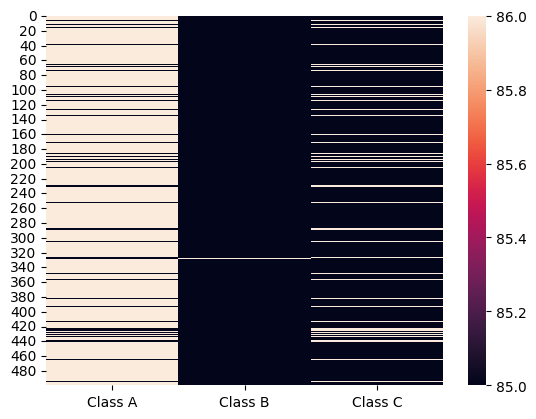

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a matrix to store the counts
class_counts = np.zeros((500, 3))

for epoch in range(500):
    for batch_idx, (data, labels) in enumerate(train_loader):
        # Count the number of examples in each class
        class_counts[epoch, 0] = np.sum(labels == 0)
        class_counts[epoch, 1] = np.sum(labels == 1)
        class_counts[epoch, 2] = np.sum(labels == 2)
    
# Convert the counts to a DataFrame
df_class_counts = pd.DataFrame(class_counts, columns=['Class A', 'Class B', 'Class C'])

# Plot the heatmap
sns.heatmap(df_class_counts)
plt.show()

What if we tried to again predict the peak shaving, and check for different predicates what is their satisfaction level.
- it would make sense that if we have a predicate: SOC <= 20 stop peak shaving, than if the treshold is good (or the rule in general), than the satisfaction of this rule will be high.
- This could also allow us to check the relation to the solar panels ? -> if the predicat that includes it does better than that that does not include it


In [4]:
# take 10% of the dataset 
data_small = s_data.sample(frac=0.99, random_state=42)


In [5]:
def check_peak_shaving(row):
    if row['GARAGE_EXTERNAL_POWER'] >= row['DEMAND_LIMIT']:
        return True
    else:
        return False

data_small['Peak_Shaving'] = data_small.apply(check_peak_shaving, axis=1)


In [6]:
# Define the thresholds
battery_discharge_power_threshold = 0
pv_power_threshold = 0.5

def adjust_peak_shaving(row):
    if row['Peak_Shaving'] == True:
        if row['BATTERY_DISCHARGE_POWER'] > battery_discharge_power_threshold or row['PV_POWER'] > pv_power_threshold:
            return True
        else:
            return False
    else:
        return False



In [7]:
data_small['Peak_Shaving'] = data_small.apply(adjust_peak_shaving, axis=1)

In [8]:
data_small

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,Peak_Shaving
35762,2023-10-31 12:34:00+00:00,1.052765,50.0,40.5,-0.232000,0.0,0.000000,0.912828,0.015625,False
5687,2023-10-08 23:00:00+00:00,1.244171,50.0,40.5,-0.317000,0.0,0.000000,0.009138,0.000000,False
56605,2023-11-17 00:43:00+00:00,26.796896,50.0,41.0,-0.422000,0.0,0.000000,0.003416,0.000000,False
34300,2023-10-30 12:12:00+00:00,49.957039,50.0,21.0,46.626003,0.0,0.800781,2.144122,0.046875,False
30633,2023-10-27 14:37:00+00:00,9.857449,50.0,54.5,-0.351000,0.0,0.000000,0.452726,0.003906,False
...,...,...,...,...,...,...,...,...,...,...
25598,2023-10-23 02:38:00+00:00,1.244171,50.0,41.0,-0.454000,0.0,0.000000,0.008325,0.000000,False
53452,2023-11-14 20:09:00+00:00,5.646513,50.0,40.5,-0.187000,0.0,0.000000,0.007033,0.000000,False
49352,2023-11-11 23:48:00+00:00,0.957061,50.0,40.5,-0.211000,0.0,0.000000,0.007655,0.000000,False
12276,2023-10-13 20:31:00+00:00,1.244171,50.0,41.0,-0.407000,0.0,0.000000,0.008098,0.000000,False


In [8]:
features = data_small.drop(['_time','Peak_Shaving','DEMAND_LIMIT', 'BATTERY_CHARGED_ENERGY',  'BATTERY_DISCHARGED_ENERGY'], axis=1)
target = data_small['Peak_Shaving']

In [20]:
features

,GARAGE_EXTERNAL_POWER,BATTERY_SOC,BATTERY_DISCHARGE_POWER,PV_POWER,PV_ENERGY
35762,1.052765,40.5,-0.232000,0.912828,0.015625
5687,1.244171,40.5,-0.317000,0.009138,0.000000
56605,26.796896,41.0,-0.422000,0.003416,0.000000
34300,49.957039,21.0,46.626003,2.144122,0.046875
30633,9.857449,54.5,-0.351000,0.452726,0.003906
...,...,...,...,...,...
25598,1.244171,41.0,-0.454000,0.008325,0.000000
53452,5.646513,40.5,-0.187000,0.007033,0.000000
49352,0.957061,40.5,-0.211000,0.007655,0.000000
12276,1.244171,41.0,-0.407000,0.008098,0.000000


In [9]:

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [10]:
features_train = torch.tensor(features_train.to_numpy()).float()
target_train = torch.tensor(target_train.to_numpy()).float()
features_test = torch.tensor(features_test.to_numpy()).float()
target_test = torch.tensor(target_test.to_numpy()).float()

Lets try first with a simple rule 
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT and SOC >= 15%

In [11]:
import ltn
# we define predicate A
class ModelA(torch.nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.sigmoid = torch.nn.Sigmoid()
        self.layer1 = torch.nn.Linear(5, 16)  
        self.layer2 = torch.nn.Linear(16, 16)
        self.layer3 = torch.nn.Linear(16, 1)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.layer1(x))
        x = self.elu(self.layer2(x))
        return self.sigmoid(self.layer3(x))


A = ltn.Predicate(ModelA())

And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

In [12]:
from sklearn.metrics import accuracy_score
import numpy as np

# this is a standard PyTorch DataLoader to load the dataset for the training and testing of the model
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = np.unique(labels) 

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        # Create a list of indices for each class
        indices_per_class = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

        # Calculate the number of samples per class in each batch
        samples_per_class = max(1, self.batch_size // len(self.unique_labels))

        for _ in range(len(self)):
            batch_indices = []

            for label in self.unique_labels:
                # Randomly sample indices for this class
                class_indices = np.random.choice(indices_per_class[label], size=samples_per_class, replace=True)
                batch_indices.extend(class_indices)

            # If the batch size is not a multiple of the number of classes, fill the rest of the batch randomly
            if len(batch_indices) < self.batch_size:
                extra_indices = np.random.choice(np.arange(len(self.labels)), size=self.batch_size - len(batch_indices))
                batch_indices.extend(extra_indices)

            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield self.data[batch_indices], self.labels[batch_indices]


# define metrics for evaluation of the model

# it computes the overall satisfaction level on the knowledge base using the given data loader (train or test)
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[torch.nonzero(labels)])  # positive examples
        x_not_A = ltn.Variable("x_not_A",
                               data[torch.nonzero(torch.logical_not(labels))])  # negative examples
        mean_sat += SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
    mean_sat /= len(loader)
    return mean_sat

# it computes the overall accuracy of the predictions of the trained model using the given data loader
# (train or test)
def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = A.model(data).detach().numpy()
        predictions = np.where(predictions > 0.5, 1., 0.).flatten()
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)

# create train and test loader, 50 points each
# batch size is 64, meaning there is only one batch for epoch
train_loader = DataLoader(features_train, target_train, 1024, True)
test_loader = DataLoader(features_test, target_test, 1024, False)

In [106]:
# # def P(tensor):
# #     print(tensor)
# #     external_power, demand_limit, soc = tensor
# #     return (external_power > demand_limit) & (soc >= 15)
# def P(tensor):
#     # print(tensor)
#     external_power, soc = tensor.t()  # transpose the tensor
#     return external_power > 50
#     # return (external_power < demand_limit)
#     # return (external_power > demand_limit) & (soc >= 15)

# # Wrap the predicate in an LTN Predicate
# P = ltn.Predicate(None, P)

In [107]:
# def Q(tensor):
#     return tensor >= 0.5  # returns True if p_shav is True

# # Wrap the predicate in an LTN Predicate
# Q = ltn.Predicate(None, Q)

In [128]:
# soc_tensor = torch.tensor(s_data['BATTERY_SOC'].values, dtype=torch.float32)
# external_power_tensor = torch.tensor(s_data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
# p_shav = torch.tensor(s_data['Peak_Shaving'].values, dtype=torch.float32)


# def phi(external_power_tensor, soc_tensor, p_shav):
#     # Stack the tensors along the last dimension to create a single tensor
#     data = torch.stack([external_power_tensor, soc_tensor], dim=-1)

#     # Create a variable that represents the data
#     p = ltn.Variable("p", data)
#     q = ltn.Variable("q", p_shav)

#     # Return the satisfaction degree of the formula
#     return Forall(p, Implies(P(p), Q(q))).value

In [48]:
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

# training of the predicate A using a loss containing the satisfaction level of the knowledge base
# the objective it to maximize the satisfaction level of the knowledge base
for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels==1]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[labels==0]) # negative examples
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A)))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 1 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.5533 | Train Sat 0.583 | Test Sat 0.583 | Train Acc 0.811 | Test Acc 0.812
 epoch 1 | loss 0.3595 | Train Sat 0.680 | Test Sat 0.685 | Train Acc 0.878 | Test Acc 0.892
 epoch 2 | loss 0.2965 | Train Sat 0.722 | Test Sat 0.725 | Train Acc 0.898 | Test Acc 0.912
 epoch 3 | loss 0.2715 | Train Sat 0.734 | Test Sat 0.749 | Train Acc 0.914 | Test Acc 0.925


KeyboardInterrupt: 

In [25]:
features

,GARAGE_EXTERNAL_POWER,BATTERY_SOC,BATTERY_DISCHARGE_POWER,PV_POWER,PV_ENERGY
35762,1.052765,40.5,-0.232000,0.912828,0.015625
5687,1.244171,40.5,-0.317000,0.009138,0.000000
56605,26.796896,41.0,-0.422000,0.003416,0.000000
34300,49.957039,21.0,46.626003,2.144122,0.046875
30633,9.857449,54.5,-0.351000,0.452726,0.003906
...,...,...,...,...,...
25598,1.244171,41.0,-0.454000,0.008325,0.000000
53452,5.646513,40.5,-0.187000,0.007033,0.000000
49352,0.957061,40.5,-0.211000,0.007655,0.000000
12276,1.244171,41.0,-0.407000,0.008098,0.000000


Axioms

- for every instance if peak shaving is true than Battery_SOC > 15:

In [13]:
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())

def PeakShaving(tensor):
    return tensor >= 0.5  # returns True if peak shaving is True

PeakShaving = ltn.Predicate(None, PeakShaving)

def Battery_SOC_Greater_15(tensor):
    return tensor > 35  # returns True if Battery_SOC > 15

Battery_SOC_Greater_15 = ltn.Predicate(None, Battery_SOC_Greater_15)

def Battery_SOC_small(tensor):
    return tensor < 45  # returns True if Battery_SOC > 15

Battery_SOC_small = ltn.Predicate(None, Battery_SOC_small)

def phi(features, label):
   
    label = label.view(-1, 1)
    sc = features[1].view(-1,1)
    # x = ltn.Variable("x", features)
    y = ltn.Variable("y", label)
    s = ltn.Variable("s", sc)
    return Forall([y, s], Implies(PeakShaving(y), And(Battery_SOC_Greater_15(s), Battery_SOC_small(s))), p=5)



# lets check the satisfaction for the rule that




# def phi2(features, label):
#     label = label.view(-1, 1)
#     sc = features[1].view(-1,1)

#     y = ltn.Variable("y", label)

#     # if there is peak shaving both 
    # return Forall()
def compute_sat_level_phi(loader, phi):
    sat_values = []
    for features, labels in loader:
        for feature, label in zip(features, labels):
            sat_values.append(phi(feature, label).value)
    mean_sat = torch.mean(torch.stack(sat_values))
    return mean_sat


What could be interesting is more general rules, that don't require the tresholds
- for all x if peak shaving than energy is given from both sources 

In [14]:
# energy comes from the power plant and the battery
def gives_energy(tensor):
    # print(tensor)
    return tensor > 0

gives_energy = ltn.Predicate(None, gives_energy)

def phiComp(features, label):
    label = label.view(-1, 1)
    bp = features[2].view(-1,1) #batery power
    pp = features[3].view(-1,1) #batery power
    # x = ltn.Variable("x", features)
    y = ltn.Variable("y", label)
    b = ltn.Variable("b", bp)
    p = ltn.Variable("p", pp)
    return Forall([y, b, p], Implies(PeakShaving(y), And(gives_energy(b), gives_energy(p))), p=5)


In [15]:
# energy comes from the power plant and the battery
def gives_energy(tensor):
    # print(tensor)
    return tensor > 0

def gets_charged(tensor):
    # print(tensor)
    return tensor < 0

gives_energy = ltn.Predicate(None, gives_energy)
gets_charged = ltn.Predicate(None, gets_charged)

def phit2(features, label):
    label = label.view(-1, 1)
    bp = features[2].view(-1,1) #batery power
    pp = features[3].view(-1,1) #batery power
    # x = ltn.Variable("x", features)
    # y = ltn.Variable("y", label)
    b = ltn.Variable("b", bp)
    p = ltn.Variable("p", pp)
    return Forall([b, p], Implies(gives_energy(p), gives_energy(b)), p=5)


In [37]:
compute_sat_level_phi(test_loader, phi)

tensor(0.7605)

In [17]:
compute_sat_level_phi(test_loader, phiComp)

tensor(0.7875)

In [18]:
compute_sat_level_phi(train_loader, phit2)

tensor(0.4689)

In [28]:
# class ModelP2(torch.nn.Module):
#     def __init__(self):
#         super(ModelP2, self).__init__()
#         self.elu = torch.nn.ELU()
#         self.sigmoid = torch.nn.Sigmoid()
#         self.dense1 = torch.nn.Linear(3, 5)
#         self.dense2 = torch.nn.Linear(5, 1) # returns one value in [0,1]

#         # Add thresholds as parameters
#         self.tr1 = torch.nn.Parameter(torch.tensor([0.]))
#         self.tr2 = torch.nn.Parameter(torch.tensor([0.]))
#         self.tr3 = torch.nn.Parameter(torch.tensor([0.]))

#     def forward(self, x):
#         x = self.elu(self.dense1(x))
#         x = self.sigmoid(self.dense2(x))

#         # Apply thresholds
#         x = torch.where(x > self.tr1, torch.tensor([1.]), x)
#         x = torch.where((x > self.tr2) & (x <= self.tr1), torch.tensor([0.5]), x)
#         x = torch.where(x <= self.tr2, torch.tensor([0.]), x)

#         return x

# modelP2 = ModelP2()
# P2 = ltn.Predicate(model=modelP2)

In [32]:
# modelP2 = ModelP2()
# P2 = ltn.Predicate(model=modelP2)

In [36]:
# tr1 = ltn.Constant(torch.tensor([0]), trainable=True)
# tr2 = ltn.Constant(torch.tensor([0]), trainable=True)
# tr3 = ltn.Constant(torch.tensor([0]), trainable=True)

# trl = ltn.Variable('trl', torch.stack([tr1.value, tr2.value, tr3.value]))


# def phi_tres(features, label):
#     label = label.view(-1, 1)
#     sc = features[1].view(-1,1)
#     y = ltn.Variable("y", label)
#     s = ltn.Variable("s", sc)
#     t = ltn.Variable("t", tresholds)
#     return Forall([y, s, t], Implies(PeakShaving(y), And(Battery_SOC_Greater_15(s), Battery_SOC_small(s), s > t)), p=5)

# def phi_tres():
#     t = ltn.Variable("t", torch.stack([i.value for i in tresholds.values()]))
#     return Forall(t, Implies(C(p), S(p)), p=5).value

In [ ]:
# res = P2(trl)

In [20]:
# params = list(A.parameters())
optimizer = torch.optim.Adam(A.parameters(), lr=0.001)

# training of the predicate A using a loss containing the satisfaction level of the knowledge base
# the objective it to maximize the satisfaction level of the knowledge base
for epoch in range(500):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels==1]) # positive examples
        x_not_A = ltn.Variable("x_not_A", data[labels==0]) # negative examples
        # p_shav = labels
        sat_agg = SatAgg(
            Forall(x_A, A(x_A)),
            Forall(x_not_A, Not(A(x_not_A))),
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f | Phi Sat %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader), compute_sat_level_phi(test_loader, phit2)))

 epoch 0 | loss 0.2227 | Train Sat 0.780 | Test Sat 0.777 | Train Acc 0.948 | Test Acc 0.943 | Phi Sat 0.488
 epoch 20 | loss 0.2127 | Train Sat 0.783 | Test Sat 0.785 | Train Acc 0.947 | Test Acc 0.948 | Phi Sat 0.490
 epoch 40 | loss 0.2116 | Train Sat 0.786 | Test Sat 0.785 | Train Acc 0.949 | Test Acc 0.950 | Phi Sat 0.486
 epoch 60 | loss 0.2108 | Train Sat 0.790 | Test Sat 0.793 | Train Acc 0.950 | Test Acc 0.949 | Phi Sat 0.489
 epoch 80 | loss 0.2103 | Train Sat 0.791 | Test Sat 0.784 | Train Acc 0.951 | Test Acc 0.946 | Phi Sat 0.484
 epoch 100 | loss 0.2067 | Train Sat 0.794 | Test Sat 0.793 | Train Acc 0.952 | Test Acc 0.952 | Phi Sat 0.490
 epoch 120 | loss 0.2109 | Train Sat 0.793 | Test Sat 0.789 | Train Acc 0.949 | Test Acc 0.953 | Phi Sat 0.488
 epoch 140 | loss 0.2022 | Train Sat 0.798 | Test Sat 0.790 | Train Acc 0.952 | Test Acc 0.949 | Phi Sat 0.479
 epoch 160 | loss 0.2045 | Train Sat 0.795 | Test Sat 0.799 | Train Acc 0.952 | Test Acc 0.949 | Phi Sat 0.487
 epoch 

KeyboardInterrupt: 

Plan for now: 
- check whith a more complicated new rule how does the satisfaction work 

Idea:
- to learn the treshold we need to save them as variables and create another Predicate to optimze them. But what do we base the optimization on? 

What can we use for loss? Assuming we want to learn tresholds, what would we use to validate how good we do on the data? 
- Maybe based on my simple labeled peak shaving? -- For which values is the peak shaving true. Should this be done with another NN model? I guess we save the tresholds as predicates, similarly as I did with Battery_SOC_Greater_15, but the treshold has to be learnable. 

### Model that guesses peak shaving based on the ground truth

For what SOC
- e-cars charging is completely covered by the local battery
- e-cars charging power is covered by local battery.
- local battery is charged from the grid.
- Battery discharging is stopped due to battery health


In [38]:
ds = pd.read_csv('src\data\Stud_E-mobility_data_staticLimit.csv')

In [39]:
ds["POWER_DEMAND"] = ds["WALLBOX_1_POWER"] + ds["WALLBOX_2_POWER"] + ds["WALLBOX_3_POWER"] + ds["WALLBOX_A_POWER"] + ds["WALLBOX_B_POWER"] + ds["WALLBOX_C_POWER"] + ds["WALLBOX_FASTCHARGER_POWER"]
ds["POWER_SUPPLY"] = ds["GARAGE_EXTERNAL_POWER"] + ds["PV_POWER"] + ds["BATTERY_DISCHARGE_POWER"]

e-cars charging is completely covered by the local battery

In [73]:
is_covered_prc = ((ds["BATTERY_DISCHARGE_POWER"] / ds["POWER_SUPPLY"]) >= 0.98).any()

print(f"Does 'BATTERY_DISCHARGE_POWER' ever cover 100% of 'POWER_SUPPLY'? {is_covered_prc}")

Does 'BATTERY_DISCHARGE_POWER' ever cover 100% of 'POWER_SUPPLY'? True


In [96]:
len(ds[ds["BATTERY_DISCHARGE_POWER"] / ds["POWER_SUPPLY"] < 0])

52480

In [95]:
len(ds[ds["BATTERY_DISCHARGE_POWER"] < 0])

52504

In [97]:
def label_row(row):
    if row["BATTERY_DISCHARGE_POWER"] / row["POWER_SUPPLY"] >= 0.95:
        return "completely covered"
    elif row["BATTERY_DISCHARGE_POWER"] > 0.05:
        return "covered"
    elif row["BATTERY_DISCHARGE_POWER"] < 0:
        return "charged"
    else:
        return "stopped"
    

ds["Label"] = ds.apply(lambda row: label_row(row), axis=1)

In [98]:
# give me counts of unique values of labels
ds["Label"].value_counts()

Label
charged               52479
covered                6927
completely covered       27
stopped                   9
Name: count, dtype: int64

In [116]:
def label_row(row):
    if row["BATTERY_DISCHARGE_POWER"] / row["POWER_SUPPLY"] >= 0.51:
        return "completely covered"
    elif row["BATTERY_DISCHARGE_POWER"] > 0.02:
        return "covered"
    else:
        return "charged"
    
    

ds["Label"] = ds.apply(lambda row: label_row(row), axis=1)

In [117]:
# give me counts of unique values of labels
ds["Label"].value_counts()

Label
charged               52485
covered                6779
completely covered      178
Name: count, dtype: int64

Now that we have that, we can try to optimize tresholds for SOC so that they help us predict the Label